QAOAの期待値は、nadavが提案したProxyと論文に書かれていたProxyとどのように違うのか。
今回は、Betaとgammaの初期値をX軸、Y軸に設定し、各Betaとgammaの初期値（init_beta, init_gamma）∈［０，１，２，３，４，５］^2 によって出力される期待値をZ軸として、３Dグラフを作成し、Nadavが提案したProxy（new_proxy）と論文に書かれていたProxy（paper_proxy）の違いを示す。

---

How does the expectation value of QAOA differ from the Proxy proposed by Nadav and the Proxy mentioned in the paper?

In this case, we will create a 3D graph where the initial values of Beta and Gamma are set on the X and Y axes, respectively. The expectation values produced by each combination of initial Beta and Gamma values (`init_beta`, `init_gamma`) ∈ [0, 1, 2, 3, 4, 5]^2 will be plotted on the Z axis. This graph will illustrate the differences between the Proxy proposed by Nadav (`new_proxy`) and the Proxy mentioned in the paper (`paper_proxy`).

---

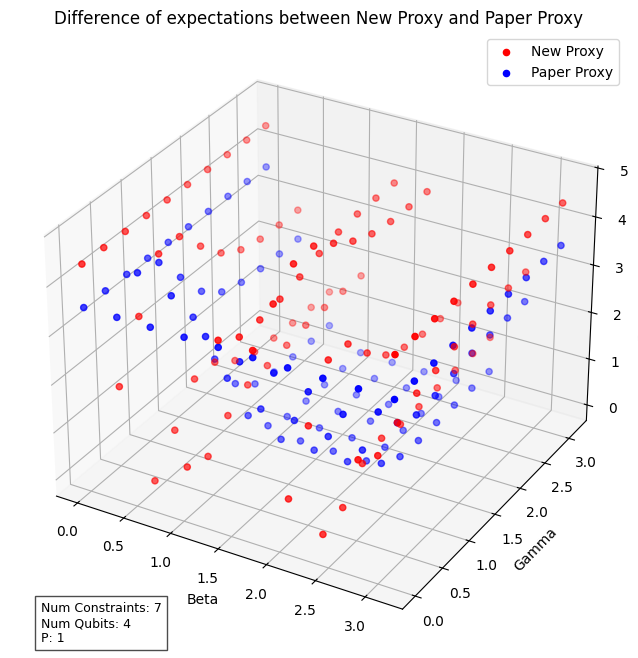

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from scipy.stats import binom, multinomial
import math
import time
from numba import njit

# シード値を設定
seed = 0
np.random.seed(seed)

# 初期パラメータを設定
num_constraints = 7  # 制約の数
num_qubits = 4       # キュービットの数
p = 1                # QAOAの層の数

# 初期値の範囲とステップサイズを設定
gamma_beta_range = np.linspace(0, np.pi, num=10)  # [0, pi]の範囲を10分割
gamma_grid, beta_grid = np.meshgrid(gamma_beta_range, gamma_beta_range)

# 結果を保存するためのリストを初期化
all_results = []

# QAOA_proxyの関数定義
@njit
def QAOA_proxy(p, gamma, beta, num_constraints, num_qubits):
    num_costs = num_constraints + 1
    amplitude_proxies = np.zeros((p + 1, num_costs), dtype=np.complex128)
    init_amplitude = np.sqrt(1 / (1 << num_qubits))
    for i in range(num_costs):
        amplitude_proxies[0][i] = init_amplitude

    for current_depth in range(1, p + 1):
        for cost_1 in range(num_costs):
            sum = 0
            for cost_2 in range(num_costs):
                for distance in range(num_qubits + 1):
                    beta_factor = (np.cos(beta[current_depth - 1]) ** (num_qubits - distance)) * ((-1j * np.sin(beta[current_depth - 1])) ** distance)
                    gamma_factor = np.exp(-1j * gamma[current_depth - 1] * cost_2)
                    num_costs_at_distance = number_of_costs_at_distance_proxy(cost_1, cost_2, distance, num_constraints, num_qubits)
                    sum += beta_factor * gamma_factor * amplitude_proxies[current_depth - 1][cost_2] * num_costs_at_distance
            amplitude_proxies[current_depth][cost_1] = sum

    expected_proxy = 0
    for cost in range(num_costs):
        expected_proxy += number_with_cost_proxy(cost, num_constraints, num_qubits) * (abs(amplitude_proxies[p][cost]) ** 2) * cost

    return amplitude_proxies, expected_proxy

@njit
def number_of_costs_at_distance_proxy(cost_1, cost_2, distance, num_constraints, num_qubits):
    # distanceがnum_qubits以下であることを保証
    # distanceがnum_qubitsより大きい場合は、distanceをnum_qubitsに修正する
    if distance > num_qubits:
        distance = num_qubits
    
    # distanceがnum_qubitsの半分を超える場合、反射距離を計算
    # 反射距離は、num_qubitsからdistanceを引いた値
    reflected_distance = distance
    if distance > num_qubits // 2:
        reflected_distance = num_qubits - distance

    # h_peakは、1 << (num_qubits - 4)として計算
    # これは、三角形の高さのピーク値である
    h_peak = 1 << (num_qubits - 4)

    # h_at_cost_2を計算するために、line_between関数を使用
    # reflected_distanceに基づいて、0から1の範囲をnum_qubits / 2に変換し、h_peakを高さとする
    h_at_cost_2 = line_between(reflected_distance, 0, 1, num_qubits / 2, h_peak)

    # centerを計算するために、line_between関数を使用
    # reflected_distanceに基づいて、0からcost_1の範囲をnum_qubits / 2に変換し、num_constraints / 2を高さとする
    center = line_between(reflected_distance, 0, cost_1, num_qubits / 2, num_constraints / 2)

    # leftとrightを計算
    # leftはcenterから反射距離と1を引いた値
    # rightはcenterから反射距離と1を加えた値
    left = center - reflected_distance - 1
    right = center + reflected_distance + 1

    # triangle_value関数を使用して、cost_2、left、right、h_at_cost_2に基づく三角形の値を計算し返す
    return triangle_value(cost_2, left, right, h_at_cost_2)


@njit
def line_between(current_time, start_time, start_value, end_time, end_value):
    if end_time == start_time:
        raise ValueError("start_time and end_time must be different.")
    relative_time = (current_time - start_time) / (end_time - start_time)
    return (1 - relative_time) * start_value + relative_time * end_value

@njit
def triangle_value(x, left, right, height):
    return max(0, min(x - left, right - x) * 2 * height / (right - left))

@njit
def prob_cost(cost, num_constraints):
    return 4 / ((num_constraints + 1) ** 2) * min(cost + 1, num_constraints + 1 - cost)

@njit
def number_with_cost_proxy(cost, num_constraints, num_qubits):
    scale = 1 << num_qubits
    return prob_cost(cost, num_constraints) * scale

# QAOA_paper_proxyの関数定義
def QAOA_paper_proxy(p, gamma, beta, num_constraints, num_qubits):
    num_costs = num_constraints + 1
    amplitude_proxies = np.zeros((p + 1, num_costs), dtype=complex)
    init_amplitude = np.sqrt(1 / (1 << num_qubits))
    for i in range(num_costs):
        amplitude_proxies[0][i] = init_amplitude

    for current_depth in range(1, p + 1):
        for cost_1 in range(num_costs):
            sum = 0
            for cost_2 in range(num_costs):
                for distance in range(num_qubits + 1):
                    beta_factor = (np.cos(beta[current_depth - 1]) ** (num_qubits - distance)) * ((-1j * np.sin(beta[current_depth - 1])) ** distance)
                    gamma_factor = np.exp(-1j * gamma[current_depth - 1] * cost_2)
                    num_costs_at_distance = number_of_costs_at_distance_paper_proxy(cost_1, cost_2, distance, num_constraints, num_qubits)
                    sum += beta_factor * gamma_factor * amplitude_proxies[current_depth - 1][cost_2] * num_costs_at_distance
            amplitude_proxies[current_depth][cost_1] = sum

    expected_proxy = 0
    for cost in range(num_costs):
        expected_proxy += number_with_cost_paper_proxy(cost, num_constraints, num_qubits) * (abs(amplitude_proxies[p][cost]) ** 2) * cost

    return amplitude_proxies, expected_proxy

def number_of_costs_at_distance_paper_proxy(cost_1, cost_2, distance, num_constraints, num_qubits, prob_edge=0.5):
    # distanceがnum_qubits以下であることを保証
    # distanceがnum_qubitsより大きい場合は、distanceをnum_qubitsに修正する
    if distance > num_qubits:
        distance = num_qubits
    
    # 合計値を初期化
    sum = 0

    # common_constraintsの範囲を決定
    # common_constraintsは、max(0, cost_1 + cost_2 - num_constraints) から min(cost_1, cost_2) まで
    for common_constraints in range(max(0, cost_1 + cost_2 - num_constraints), min(cost_1, cost_2) + 1):
        # 各common_constraintsに対して、prob_common_at_distance_paper関数を使用して値を計算し、sumに加算
        sum += prob_common_at_distance_paper(num_constraints, common_constraints, cost_1, cost_2, distance)

    # costの確率を計算するためにprob_cost_paper関数を使用
    p_cost = prob_cost_paper(cost_1, num_constraints, prob_edge)
    
    # 数量を計算して返す
    # math.comb(num_qubits, distance) は、距離distanceに対するnum_qubitsからの組み合わせ数
    # p_costで割ることで、確率を調整
    return (math.comb(num_qubits, distance) / p_cost) * sum


def prob_common_at_distance_paper(num_constraints, common_constraints, cost_1, cost_2, distance):
    # 引数の範囲をチェック
    # distance、cost_1、cost_2 が指定された範囲内にあるか確認し、範囲外の場合はエラーを発生させる
    if not (0 <= distance <= num_constraints):
        raise ValueError(f"Invalid distance value: {distance}")
    if not (0 <= cost_1 <= num_constraints):
        raise ValueError(f"Invalid cost_1 value: {cost_1}")
    if not (0 <= cost_2 <= num_constraints):
        raise ValueError(f"Invalid cost_2 value: {cost_2}")

    # 同じ制約を持つ確率を計算
    # 同じ制約を持つ確率は、distanceでの組み合わせ数に基づいて計算される
    prob_same = (math.comb(num_constraints - distance, 2) + math.comb(distance, 2)) / math.comb(num_constraints, 2)

    # 「どちらもない」確率を計算
    prob_neither = prob_same / 2
    
    # 「両方」確率を設定
    prob_both = prob_neither
    
    # 「一方」確率を計算
    prob_one = (1 - prob_neither - prob_both) / 2

    # multinomial分布に基づいて確率を計算
    # common_constraints、cost_1 - common_constraints、cost_2 - common_constraints、および残りの制約の数を元に確率を計算
    return multinomial.pmf(
        [common_constraints, cost_1 - common_constraints, cost_2 - common_constraints, num_constraints + common_constraints - (cost_1 + cost_2)],
        num_constraints,
        [prob_both, prob_one, prob_one, prob_neither],
    )



def prob_cost_paper(cost, num_constraints, prob_edge=0.5):
    return binom.pmf(cost, num_constraints, prob_edge)

def number_with_cost_paper_proxy(cost, num_constraints, num_qubits, prob_edge=0.5):
    scale = 1 << num_qubits
    return prob_cost_paper(cost, num_constraints, prob_edge) * scale

# 全ての組み合わせでループ
for i in range(gamma_grid.size):
    init_gamma = np.array([gamma_grid.ravel()[i]])
    init_beta = np.array([beta_grid.ravel()[i]])

    try:
        # QAOA_proxy を実行
        _, new_proxy_expectation = QAOA_proxy(
            p=p,
            gamma=init_gamma,
            beta=init_beta,
            num_constraints=num_constraints,
            num_qubits=num_qubits
        )

        # QAOA_paper_proxy を実行
        _, paper_proxy_expectation = QAOA_paper_proxy(
            p=p,
            gamma=init_gamma,
            beta=init_beta,
            num_constraints=num_constraints,
            num_qubits=num_qubits
        )

        # 結果を保存
        all_results.append({
            "init_gamma": init_gamma,
            "init_beta": init_beta,
            "new_proxy_expectation": new_proxy_expectation,
            "paper_proxy_expectation": paper_proxy_expectation
        })

    except ValueError as e:
        print(f"Error occurred at index {i}: {e}")

# データのリストからデータを抽出
gamma_vals = [result["init_gamma"][0] for result in all_results]
beta_vals = [result["init_beta"][0] for result in all_results]
new_proxy_vals = [result["new_proxy_expectation"] for result in all_results]
paper_proxy_vals = [result["paper_proxy_expectation"] for result in all_results]

# プロット
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# `new_proxy_vals` 用の散布図
sc1 = ax.scatter(beta_vals, gamma_vals, new_proxy_vals, c='red', label='New Proxy')

# `paper_proxy_vals` 用の散布図
sc2 = ax.scatter(beta_vals, gamma_vals, paper_proxy_vals, c='blue', label='Paper Proxy')

# ラベルとタイトル
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
ax.set_zlabel('Expected Value')
ax.set_title('Difference of expectations between New Proxy and Paper Proxy')

# 凡例
ax.legend()

# グリッド
ax.grid(True)

# グラフ内にテキストを追加
ax.text2D(0.05, 0.01, f'Num Constraints: {num_constraints}\nNum Qubits: {num_qubits}\nP: {p}', 
          transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

# プロットの表示
plt.show()



Pの値を変更すると、Betaとgammaの次数が上がってしまうので、
P=1は固定したまま、制約数（number of constraints）や量子ビット数（number of qubits）を変更した場合についても同様にグラフを作成する。

---

When changing the value of \( P \), the degrees of Beta and Gamma increase, so we will keep \( P = 1 \) fixed and create similar graphs for different numbers of constraints and quantum bits.

---

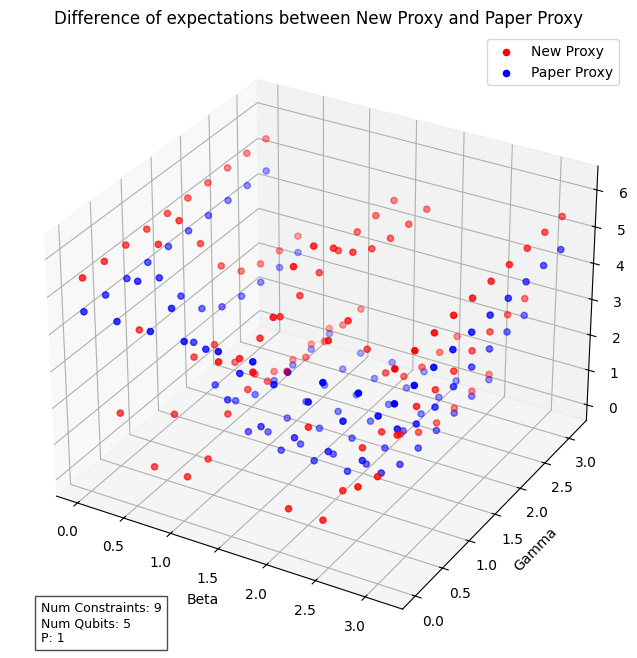

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from scipy.stats import binom, multinomial
import math
import time
from numba import njit

# シード値を設定
seed = 0
np.random.seed(seed)

# 初期パラメータを設定
num_constraints = 9  # 制約の数
num_qubits = 5       # キュービットの数
p = 1                # QAOAの層の数

# 初期値の範囲とステップサイズを設定
gamma_beta_range = np.linspace(0, np.pi, num=10)  # [0, pi]の範囲を10分割
gamma_grid, beta_grid = np.meshgrid(gamma_beta_range, gamma_beta_range)

# 結果を保存するためのリストを初期化
all_results = []

# QAOA_proxyの関数定義
@njit
def QAOA_proxy(p, gamma, beta, num_constraints, num_qubits):
    num_costs = num_constraints + 1
    amplitude_proxies = np.zeros((p + 1, num_costs), dtype=np.complex128)
    init_amplitude = np.sqrt(1 / (1 << num_qubits))
    for i in range(num_costs):
        amplitude_proxies[0][i] = init_amplitude

    for current_depth in range(1, p + 1):
        for cost_1 in range(num_costs):
            sum = 0
            for cost_2 in range(num_costs):
                for distance in range(num_qubits + 1):
                    beta_factor = (np.cos(beta[current_depth - 1]) ** (num_qubits - distance)) * ((-1j * np.sin(beta[current_depth - 1])) ** distance)
                    gamma_factor = np.exp(-1j * gamma[current_depth - 1] * cost_2)
                    num_costs_at_distance = number_of_costs_at_distance_proxy(cost_1, cost_2, distance, num_constraints, num_qubits)
                    sum += beta_factor * gamma_factor * amplitude_proxies[current_depth - 1][cost_2] * num_costs_at_distance
            amplitude_proxies[current_depth][cost_1] = sum

    expected_proxy = 0
    for cost in range(num_costs):
        expected_proxy += number_with_cost_proxy(cost, num_constraints, num_qubits) * (abs(amplitude_proxies[p][cost]) ** 2) * cost

    return amplitude_proxies, expected_proxy

@njit
def number_of_costs_at_distance_proxy(cost_1, cost_2, distance, num_constraints, num_qubits):
    # distanceがnum_qubits以下であることを保証
    # distanceがnum_qubitsより大きい場合は、distanceをnum_qubitsに修正する
    if distance > num_qubits:
        distance = num_qubits
    
    # distanceがnum_qubitsの半分を超える場合、反射距離を計算
    # 反射距離は、num_qubitsからdistanceを引いた値
    reflected_distance = distance
    if distance > num_qubits // 2:
        reflected_distance = num_qubits - distance

    # h_peakは、1 << (num_qubits - 4)として計算
    # これは、三角形の高さのピーク値である
    h_peak = 1 << (num_qubits - 4)

    # h_at_cost_2を計算するために、line_between関数を使用
    # reflected_distanceに基づいて、0から1の範囲をnum_qubits / 2に変換し、h_peakを高さとする
    h_at_cost_2 = line_between(reflected_distance, 0, 1, num_qubits / 2, h_peak)

    # centerを計算するために、line_between関数を使用
    # reflected_distanceに基づいて、0からcost_1の範囲をnum_qubits / 2に変換し、num_constraints / 2を高さとする
    center = line_between(reflected_distance, 0, cost_1, num_qubits / 2, num_constraints / 2)

    # leftとrightを計算
    # leftはcenterから反射距離と1を引いた値
    # rightはcenterから反射距離と1を加えた値
    left = center - reflected_distance - 1
    right = center + reflected_distance + 1

    # triangle_value関数を使用して、cost_2、left、right、h_at_cost_2に基づく三角形の値を計算し返す
    return triangle_value(cost_2, left, right, h_at_cost_2)


@njit
def line_between(current_time, start_time, start_value, end_time, end_value):
    if end_time == start_time:
        raise ValueError("start_time and end_time must be different.")
    relative_time = (current_time - start_time) / (end_time - start_time)
    return (1 - relative_time) * start_value + relative_time * end_value

@njit
def triangle_value(x, left, right, height):
    return max(0, min(x - left, right - x) * 2 * height / (right - left))

@njit
def prob_cost(cost, num_constraints):
    return 4 / ((num_constraints + 1) ** 2) * min(cost + 1, num_constraints + 1 - cost)

@njit
def number_with_cost_proxy(cost, num_constraints, num_qubits):
    scale = 1 << num_qubits
    return prob_cost(cost, num_constraints) * scale

# QAOA_paper_proxyの関数定義
def QAOA_paper_proxy(p, gamma, beta, num_constraints, num_qubits):
    num_costs = num_constraints + 1
    amplitude_proxies = np.zeros((p + 1, num_costs), dtype=complex)
    init_amplitude = np.sqrt(1 / (1 << num_qubits))
    for i in range(num_costs):
        amplitude_proxies[0][i] = init_amplitude

    for current_depth in range(1, p + 1):
        for cost_1 in range(num_costs):
            sum = 0
            for cost_2 in range(num_costs):
                for distance in range(num_qubits + 1):
                    beta_factor = (np.cos(beta[current_depth - 1]) ** (num_qubits - distance)) * ((-1j * np.sin(beta[current_depth - 1])) ** distance)
                    gamma_factor = np.exp(-1j * gamma[current_depth - 1] * cost_2)
                    num_costs_at_distance = number_of_costs_at_distance_paper_proxy(cost_1, cost_2, distance, num_constraints, num_qubits)
                    sum += beta_factor * gamma_factor * amplitude_proxies[current_depth - 1][cost_2] * num_costs_at_distance
            amplitude_proxies[current_depth][cost_1] = sum

    expected_proxy = 0
    for cost in range(num_costs):
        expected_proxy += number_with_cost_paper_proxy(cost, num_constraints, num_qubits) * (abs(amplitude_proxies[p][cost]) ** 2) * cost

    return amplitude_proxies, expected_proxy

def number_of_costs_at_distance_paper_proxy(cost_1, cost_2, distance, num_constraints, num_qubits, prob_edge=0.5):
    # distanceがnum_qubits以下であることを保証
    # distanceがnum_qubitsより大きい場合は、distanceをnum_qubitsに修正する
    if distance > num_qubits:
        distance = num_qubits
    
    # 合計値を初期化
    sum = 0

    # common_constraintsの範囲を決定
    # common_constraintsは、max(0, cost_1 + cost_2 - num_constraints) から min(cost_1, cost_2) まで
    for common_constraints in range(max(0, cost_1 + cost_2 - num_constraints), min(cost_1, cost_2) + 1):
        # 各common_constraintsに対して、prob_common_at_distance_paper関数を使用して値を計算し、sumに加算
        sum += prob_common_at_distance_paper(num_constraints, common_constraints, cost_1, cost_2, distance)

    # costの確率を計算するためにprob_cost_paper関数を使用
    p_cost = prob_cost_paper(cost_1, num_constraints, prob_edge)
    
    # 数量を計算して返す
    # math.comb(num_qubits, distance) は、距離distanceに対するnum_qubitsからの組み合わせ数
    # p_costで割ることで、確率を調整
    return (math.comb(num_qubits, distance) / p_cost) * sum


def prob_common_at_distance_paper(num_constraints, common_constraints, cost_1, cost_2, distance):
    # 引数の範囲をチェック
    # distance、cost_1、cost_2 が指定された範囲内にあるか確認し、範囲外の場合はエラーを発生させる
    if not (0 <= distance <= num_constraints):
        raise ValueError(f"Invalid distance value: {distance}")
    if not (0 <= cost_1 <= num_constraints):
        raise ValueError(f"Invalid cost_1 value: {cost_1}")
    if not (0 <= cost_2 <= num_constraints):
        raise ValueError(f"Invalid cost_2 value: {cost_2}")

    # 同じ制約を持つ確率を計算
    # 同じ制約を持つ確率は、distanceでの組み合わせ数に基づいて計算される
    prob_same = (math.comb(num_constraints - distance, 2) + math.comb(distance, 2)) / math.comb(num_constraints, 2)

    # 「どちらもない」確率を計算
    prob_neither = prob_same / 2
    
    # 「両方」確率を設定
    prob_both = prob_neither
    
    # 「一方」確率を計算
    prob_one = (1 - prob_neither - prob_both) / 2

    # multinomial分布に基づいて確率を計算
    # common_constraints、cost_1 - common_constraints、cost_2 - common_constraints、および残りの制約の数を元に確率を計算
    return multinomial.pmf(
        [common_constraints, cost_1 - common_constraints, cost_2 - common_constraints, num_constraints + common_constraints - (cost_1 + cost_2)],
        num_constraints,
        [prob_both, prob_one, prob_one, prob_neither],
    )



def prob_cost_paper(cost, num_constraints, prob_edge=0.5):
    return binom.pmf(cost, num_constraints, prob_edge)

def number_with_cost_paper_proxy(cost, num_constraints, num_qubits, prob_edge=0.5):
    scale = 1 << num_qubits
    return prob_cost_paper(cost, num_constraints, prob_edge) * scale

# 全ての組み合わせでループ
for i in range(gamma_grid.size):
    init_gamma = np.array([gamma_grid.ravel()[i]])
    init_beta = np.array([beta_grid.ravel()[i]])

    try:
        # QAOA_proxy を実行
        _, new_proxy_expectation = QAOA_proxy(
            p=p,
            gamma=init_gamma,
            beta=init_beta,
            num_constraints=num_constraints,
            num_qubits=num_qubits
        )

        # QAOA_paper_proxy を実行
        _, paper_proxy_expectation = QAOA_paper_proxy(
            p=p,
            gamma=init_gamma,
            beta=init_beta,
            num_constraints=num_constraints,
            num_qubits=num_qubits
        )

        # 結果を保存
        all_results.append({
            "init_gamma": init_gamma,
            "init_beta": init_beta,
            "new_proxy_expectation": new_proxy_expectation,
            "paper_proxy_expectation": paper_proxy_expectation
        })

    except ValueError as e:
        print(f"Error occurred at index {i}: {e}")

# データのリストからデータを抽出
gamma_vals = [result["init_gamma"][0] for result in all_results]
beta_vals = [result["init_beta"][0] for result in all_results]
new_proxy_vals = [result["new_proxy_expectation"] for result in all_results]
paper_proxy_vals = [result["paper_proxy_expectation"] for result in all_results]

# プロット
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# `new_proxy_vals` 用の散布図
sc1 = ax.scatter(beta_vals, gamma_vals, new_proxy_vals, c='red', label='New Proxy')

# `paper_proxy_vals` 用の散布図
sc2 = ax.scatter(beta_vals, gamma_vals, paper_proxy_vals, c='blue', label='Paper Proxy')

# ラベルとタイトル
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
ax.set_zlabel('Expected Value')
ax.set_title('Difference of expectations between New Proxy and Paper Proxy')

# 凡例
ax.legend()

# グリッド
ax.grid(True)

# グラフ内にテキストを追加
ax.text2D(0.05, 0.01, f'Num Constraints: {num_constraints}\nNum Qubits: {num_qubits}\nP: {p}', 
          transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

# プロットの表示
plt.show()


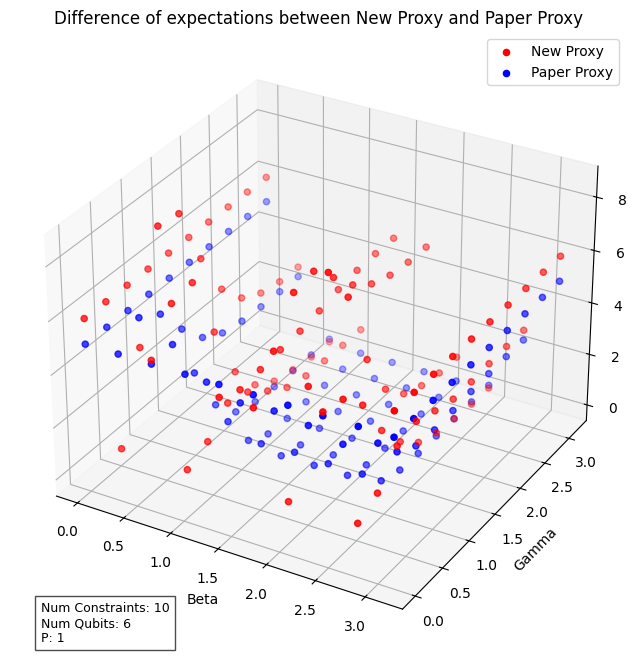

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from scipy.stats import binom, multinomial
import math
import time
from numba import njit

# シード値を設定
seed = 0
np.random.seed(seed)

# 初期パラメータを設定
num_constraints = 10  # 制約の数
num_qubits = 6       # キュービットの数
p = 1                # QAOAの層の数

# 初期値の範囲とステップサイズを設定
gamma_beta_range = np.linspace(0, np.pi, num=10)  # [0, pi]の範囲を10分割
gamma_grid, beta_grid = np.meshgrid(gamma_beta_range, gamma_beta_range)

# 結果を保存するためのリストを初期化
all_results = []

# QAOA_proxyの関数定義
@njit
def QAOA_proxy(p, gamma, beta, num_constraints, num_qubits):
    num_costs = num_constraints + 1
    amplitude_proxies = np.zeros((p + 1, num_costs), dtype=np.complex128)
    init_amplitude = np.sqrt(1 / (1 << num_qubits))
    for i in range(num_costs):
        amplitude_proxies[0][i] = init_amplitude

    for current_depth in range(1, p + 1):
        for cost_1 in range(num_costs):
            sum = 0
            for cost_2 in range(num_costs):
                for distance in range(num_qubits + 1):
                    beta_factor = (np.cos(beta[current_depth - 1]) ** (num_qubits - distance)) * ((-1j * np.sin(beta[current_depth - 1])) ** distance)
                    gamma_factor = np.exp(-1j * gamma[current_depth - 1] * cost_2)
                    num_costs_at_distance = number_of_costs_at_distance_proxy(cost_1, cost_2, distance, num_constraints, num_qubits)
                    sum += beta_factor * gamma_factor * amplitude_proxies[current_depth - 1][cost_2] * num_costs_at_distance
            amplitude_proxies[current_depth][cost_1] = sum

    expected_proxy = 0
    for cost in range(num_costs):
        expected_proxy += number_with_cost_proxy(cost, num_constraints, num_qubits) * (abs(amplitude_proxies[p][cost]) ** 2) * cost

    return amplitude_proxies, expected_proxy

@njit
def number_of_costs_at_distance_proxy(cost_1, cost_2, distance, num_constraints, num_qubits):
    # distanceがnum_qubits以下であることを保証
    # distanceがnum_qubitsより大きい場合は、distanceをnum_qubitsに修正する
    if distance > num_qubits:
        distance = num_qubits
    
    # distanceがnum_qubitsの半分を超える場合、反射距離を計算
    # 反射距離は、num_qubitsからdistanceを引いた値
    reflected_distance = distance
    if distance > num_qubits // 2:
        reflected_distance = num_qubits - distance

    # h_peakは、1 << (num_qubits - 4)として計算
    # これは、三角形の高さのピーク値である
    h_peak = 1 << (num_qubits - 4)

    # h_at_cost_2を計算するために、line_between関数を使用
    # reflected_distanceに基づいて、0から1の範囲をnum_qubits / 2に変換し、h_peakを高さとする
    h_at_cost_2 = line_between(reflected_distance, 0, 1, num_qubits / 2, h_peak)

    # centerを計算するために、line_between関数を使用
    # reflected_distanceに基づいて、0からcost_1の範囲をnum_qubits / 2に変換し、num_constraints / 2を高さとする
    center = line_between(reflected_distance, 0, cost_1, num_qubits / 2, num_constraints / 2)

    # leftとrightを計算
    # leftはcenterから反射距離と1を引いた値
    # rightはcenterから反射距離と1を加えた値
    left = center - reflected_distance - 1
    right = center + reflected_distance + 1

    # triangle_value関数を使用して、cost_2、left、right、h_at_cost_2に基づく三角形の値を計算し返す
    return triangle_value(cost_2, left, right, h_at_cost_2)


@njit
def line_between(current_time, start_time, start_value, end_time, end_value):
    if end_time == start_time:
        raise ValueError("start_time and end_time must be different.")
    relative_time = (current_time - start_time) / (end_time - start_time)
    return (1 - relative_time) * start_value + relative_time * end_value

@njit
def triangle_value(x, left, right, height):
    return max(0, min(x - left, right - x) * 2 * height / (right - left))

@njit
def prob_cost(cost, num_constraints):
    return 4 / ((num_constraints + 1) ** 2) * min(cost + 1, num_constraints + 1 - cost)

@njit
def number_with_cost_proxy(cost, num_constraints, num_qubits):
    scale = 1 << num_qubits
    return prob_cost(cost, num_constraints) * scale

# QAOA_paper_proxyの関数定義
def QAOA_paper_proxy(p, gamma, beta, num_constraints, num_qubits):
    num_costs = num_constraints + 1
    amplitude_proxies = np.zeros((p + 1, num_costs), dtype=complex)
    init_amplitude = np.sqrt(1 / (1 << num_qubits))
    for i in range(num_costs):
        amplitude_proxies[0][i] = init_amplitude

    for current_depth in range(1, p + 1):
        for cost_1 in range(num_costs):
            sum = 0
            for cost_2 in range(num_costs):
                for distance in range(num_qubits + 1):
                    beta_factor = (np.cos(beta[current_depth - 1]) ** (num_qubits - distance)) * ((-1j * np.sin(beta[current_depth - 1])) ** distance)
                    gamma_factor = np.exp(-1j * gamma[current_depth - 1] * cost_2)
                    num_costs_at_distance = number_of_costs_at_distance_paper_proxy(cost_1, cost_2, distance, num_constraints, num_qubits)
                    sum += beta_factor * gamma_factor * amplitude_proxies[current_depth - 1][cost_2] * num_costs_at_distance
            amplitude_proxies[current_depth][cost_1] = sum

    expected_proxy = 0
    for cost in range(num_costs):
        expected_proxy += number_with_cost_paper_proxy(cost, num_constraints, num_qubits) * (abs(amplitude_proxies[p][cost]) ** 2) * cost

    return amplitude_proxies, expected_proxy

def number_of_costs_at_distance_paper_proxy(cost_1, cost_2, distance, num_constraints, num_qubits, prob_edge=0.5):
    # distanceがnum_qubits以下であることを保証
    # distanceがnum_qubitsより大きい場合は、distanceをnum_qubitsに修正する
    if distance > num_qubits:
        distance = num_qubits
    
    # 合計値を初期化
    sum = 0

    # common_constraintsの範囲を決定
    # common_constraintsは、max(0, cost_1 + cost_2 - num_constraints) から min(cost_1, cost_2) まで
    for common_constraints in range(max(0, cost_1 + cost_2 - num_constraints), min(cost_1, cost_2) + 1):
        # 各common_constraintsに対して、prob_common_at_distance_paper関数を使用して値を計算し、sumに加算
        sum += prob_common_at_distance_paper(num_constraints, common_constraints, cost_1, cost_2, distance)

    # costの確率を計算するためにprob_cost_paper関数を使用
    p_cost = prob_cost_paper(cost_1, num_constraints, prob_edge)
    
    # 数量を計算して返す
    # math.comb(num_qubits, distance) は、距離distanceに対するnum_qubitsからの組み合わせ数
    # p_costで割ることで、確率を調整
    return (math.comb(num_qubits, distance) / p_cost) * sum


def prob_common_at_distance_paper(num_constraints, common_constraints, cost_1, cost_2, distance):
    # 引数の範囲をチェック
    # distance、cost_1、cost_2 が指定された範囲内にあるか確認し、範囲外の場合はエラーを発生させる
    if not (0 <= distance <= num_constraints):
        raise ValueError(f"Invalid distance value: {distance}")
    if not (0 <= cost_1 <= num_constraints):
        raise ValueError(f"Invalid cost_1 value: {cost_1}")
    if not (0 <= cost_2 <= num_constraints):
        raise ValueError(f"Invalid cost_2 value: {cost_2}")

    # 同じ制約を持つ確率を計算
    # 同じ制約を持つ確率は、distanceでの組み合わせ数に基づいて計算される
    prob_same = (math.comb(num_constraints - distance, 2) + math.comb(distance, 2)) / math.comb(num_constraints, 2)

    # 「どちらもない」確率を計算
    prob_neither = prob_same / 2
    
    # 「両方」確率を設定
    prob_both = prob_neither
    
    # 「一方」確率を計算
    prob_one = (1 - prob_neither - prob_both) / 2

    # multinomial分布に基づいて確率を計算
    # common_constraints、cost_1 - common_constraints、cost_2 - common_constraints、および残りの制約の数を元に確率を計算
    return multinomial.pmf(
        [common_constraints, cost_1 - common_constraints, cost_2 - common_constraints, num_constraints + common_constraints - (cost_1 + cost_2)],
        num_constraints,
        [prob_both, prob_one, prob_one, prob_neither],
    )



def prob_cost_paper(cost, num_constraints, prob_edge=0.5):
    return binom.pmf(cost, num_constraints, prob_edge)

def number_with_cost_paper_proxy(cost, num_constraints, num_qubits, prob_edge=0.5):
    scale = 1 << num_qubits
    return prob_cost_paper(cost, num_constraints, prob_edge) * scale

# 全ての組み合わせでループ
for i in range(gamma_grid.size):
    init_gamma = np.array([gamma_grid.ravel()[i]])
    init_beta = np.array([beta_grid.ravel()[i]])

    try:
        # QAOA_proxy を実行
        _, new_proxy_expectation = QAOA_proxy(
            p=p,
            gamma=init_gamma,
            beta=init_beta,
            num_constraints=num_constraints,
            num_qubits=num_qubits
        )

        # QAOA_paper_proxy を実行
        _, paper_proxy_expectation = QAOA_paper_proxy(
            p=p,
            gamma=init_gamma,
            beta=init_beta,
            num_constraints=num_constraints,
            num_qubits=num_qubits
        )

        # 結果を保存
        all_results.append({
            "init_gamma": init_gamma,
            "init_beta": init_beta,
            "new_proxy_expectation": new_proxy_expectation,
            "paper_proxy_expectation": paper_proxy_expectation
        })

    except ValueError as e:
        print(f"Error occurred at index {i}: {e}")

# データのリストからデータを抽出
gamma_vals = [result["init_gamma"][0] for result in all_results]
beta_vals = [result["init_beta"][0] for result in all_results]
new_proxy_vals = [result["new_proxy_expectation"] for result in all_results]
paper_proxy_vals = [result["paper_proxy_expectation"] for result in all_results]

# プロット
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# `new_proxy_vals` 用の散布図
sc1 = ax.scatter(beta_vals, gamma_vals, new_proxy_vals, c='red', label='New Proxy')

# `paper_proxy_vals` 用の散布図
sc2 = ax.scatter(beta_vals, gamma_vals, paper_proxy_vals, c='blue', label='Paper Proxy')

# ラベルとタイトル
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
ax.set_zlabel('Expected Value')
ax.set_title('Difference of expectations between New Proxy and Paper Proxy')

# 凡例
ax.legend()

# グリッド
ax.grid(True)

# グラフ内にテキストを追加
ax.text2D(0.05, 0.01, f'Num Constraints: {num_constraints}\nNum Qubits: {num_qubits}\nP: {p}', 
          transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

# プロットの表示
plt.show()

いくつかの初期値を試した経験上、（qubitの数）＝（制約数の1/2）+1　にすると、distanceのエラーが生じずに、このプログラムを実行することができる。しかし、それがなぜかはわからない。

---

Based on my experience testing several initial values, setting the number of qubits to (number of constraints / 2) + 1 allows the program to run without encountering distance errors. However, the reason for this is unknown.

---